# Packages and OS

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# generic packages
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm.auto import tqdm
from datetime import datetime
import pandas as pd

# # os directory
YOUR_FOLDER_DIRECTORY = os.getcwd()

# Assuming 'src' directory is located one level above the notebook directory
project_directory = os.path.join(YOUR_FOLDER_DIRECTORY, '..')
sys.path.append(project_directory)

# src code
from src.portfolio_class_240309 import Portfolio
from src.config import (
    TICKERS,
    START_DATE,
    END_DATE,
    INTERVAL,
    RISK_FREE_RATE,
    MSCI_SCORE_ALREADY_DOWNLOADED,
    FREQUENCY_RETURNS
)
from src.backtesting_score import (
    get_last_esg_scores,
    get_first_date_with_all_msci_score_available
)

# scraper code
from exploration.scrapper.scraper import (
    download_msci_esg_ratings_htmlfile,
    load_dict_from_json
)


# Download MSCI data

In [3]:
if MSCI_SCORE_ALREADY_DOWNLOADED:
    # load data
    msci_score = load_dict_from_json("../data/exemple_msci_esg_ratings_numeric.json")
else:
    # scrap data
    msci_score={}
    for ticker in tqdm(TICKERS):
        dict = download_msci_esg_ratings_htmlfile(tickers=[ticker])
        msci_score[ticker] = dict[ticker]

    for ticker in msci_score.keys():
        for key, rating in msci_score[ticker]['esg_score_dict'].items():
            key = datetime.strptime(key, '%b-%y').strftime('%Y-%m-%d')
    # # save data
    # from src.config import save_dict_to_json
    # save_dict_to_json(msci_score, "../data/exemple_msci_esg_ratings_numeric.json")
    # MSCI_SCORE_ALREADY_DOWNLOADED=True


# 1. Get optimal weights under constraints

In [4]:
actif_sans_risque = 0.02

In [5]:
END_DATE = '2022-12-01'

if datetime.strptime(END_DATE, '%Y-%m-%d') < get_first_date_with_all_msci_score_available(msci_score):
    print("ERROR: END_DATE is before the first date with all msci score available.")
    END_DATE = get_first_date_with_all_msci_score_available(msci_score)
    print(f"END_DATE is now {END_DATE}, but you can change it.")
else:
    print("Thanks for having entered a valid end date !")

Thanks for having entered a valid end date !


In [6]:
msci_last_esg_score = get_last_esg_scores(msci_score, END_DATE)

PORTFOLIO = Portfolio(TICKERS,
                      START_DATE,
                      END_DATE,
                      INTERVAL,
                      msci_last_esg_score,
                      FREQUENCY_RETURNS)

PORTFOLIO.download_data()

[*********************100%%**********************]  31 of 31 completed


In [7]:
MAX_ESG_SCORE = 60
MAX_ESG_SCORES = list(np.linspace(np.min(msci_last_esg_score), np.max(msci_last_esg_score), 30))
GAMMA_VALUES = np.linspace(-5, 5, 100)  # Inverse of the risk aversion parameter


# Exporter les tables de données

In [36]:
# data_to_keep = []
# for i in range(len(TICKERS)):
#     list_to_be_flattened = [list(msci_score[ticker]['esg_score_dict'].items()) for ticker in PORTFOLIO.tickers][i]
#     flattened_data = [item for sublist in list_to_be_flattened for item in sublist]
#     data_to_keep.append(flattened_data)
# df_data_to_keep = pd.DataFrame(data_to_keep, columns=['Date_1', 'Score_1', 'Date_2', 'Score_2', 'Date_3', 'Score_3', 'Date_4', 'Score_4', 'Date_5', 'Score_5'])
# df_data_to_keep


In [37]:
# df_to_latex = pd.DataFrame(data=PORTFOLIO.ticker_sector_dict.values(),
#                         index=PORTFOLIO.ticker_sector_dict.keys(),
#                         columns=['Sectors']).sort_values(by='Sectors').reset_index(names='Tickers')
# df_to_latex
# print(df_to_latex.to_latex())

In [38]:
# print(df_to_latex.set_index('Tickers').to_latex())

In [39]:
# print(pd.concat([df_to_latex, df_data_to_keep], axis=1).set_index('Tickers').to_latex())

In [40]:
# controverse_to_keep = []
# for i in range(len(TICKERS)):
#     controverse_colors = [list(msci_score[ticker]['controversy_info'].values()) for ticker in PORTFOLIO.tickers][i]
#     controverse_to_keep.append(controverse_colors)
# df_controverse_to_keep = pd.DataFrame(controverse_to_keep, columns=['Color for Environment', 'Color for Social', 'Color for Governance'])
# df_controverse_to_keep

In [41]:
# print(pd.concat([df_to_latex, df_controverse_to_keep], axis=1).set_index('Tickers').to_latex())

## 1.1. Market optimum

In [42]:
# mettre avec actif sans risque et sans sur le même graphique

In [43]:
RISK_FREE_RATE

0.02

faire tourner le progamme pour diff valeurs de gamma maximiser le mean-var (intégrer l'actif sans risque dans l'optim: ne pas faire comme si on connaissait la sol) -> rien ne nous dit que la captial market line reste une droite avec l'introduction d'un actif sans risque

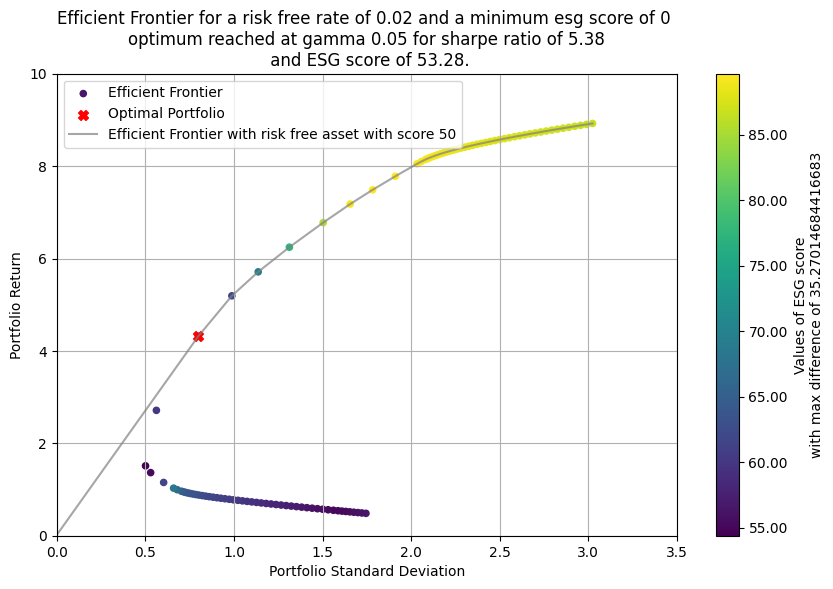

In [44]:
# efficient_frontier_no_esg_min.png
PORTFOLIO.plot_efficient_frontier(GAMMA_VALUES, 
                                  risk_free_rate=0.02,
                                  score_esg_risk_free_rate=50,
                                  max_esg_score=0, # min
                                  fully_invested=True,
                                  long_only=True,
                                  with_both_risk_free_and_without=True)


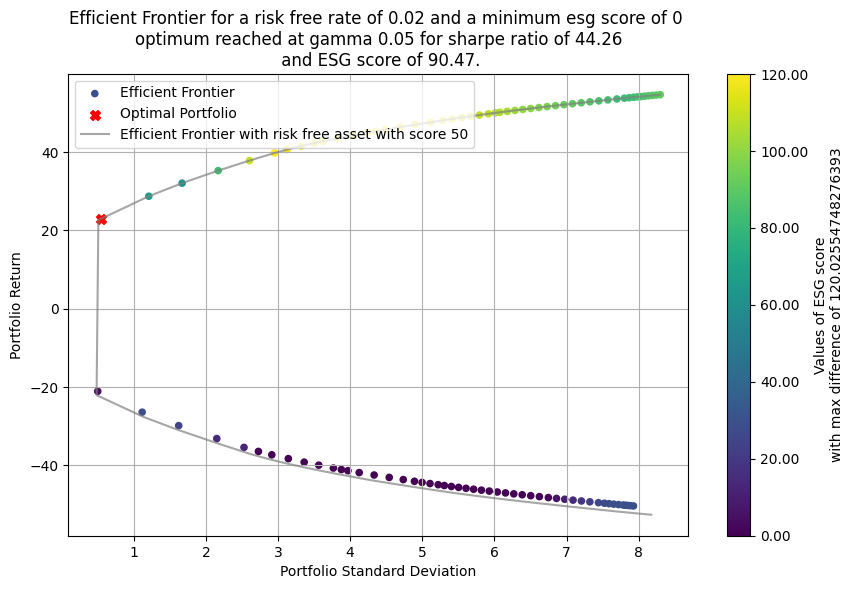

In [45]:
# efficient_frontier_no_esg_min.png
PORTFOLIO.plot_efficient_frontier(GAMMA_VALUES, 
                                  risk_free_rate=0.02,
                                  score_esg_risk_free_rate=50,
                                  max_esg_score=0, # min
                                  fully_invested=True,
                                  long_only=False,
                                  with_both_risk_free_and_without=True)


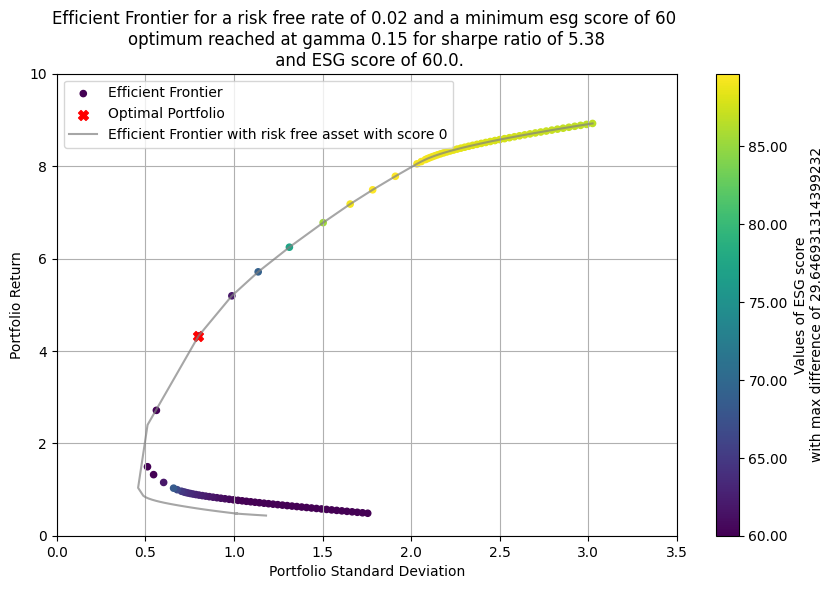

In [46]:
# efficient_frontier_60_esg_min.png
PORTFOLIO.plot_efficient_frontier(GAMMA_VALUES, 
                                  risk_free_rate=0.02,
                                  score_esg_risk_free_rate=0,
                                  max_esg_score=60, # min
                                  fully_invested=True,
                                  long_only=True,
                                  with_both_risk_free_and_without=True)


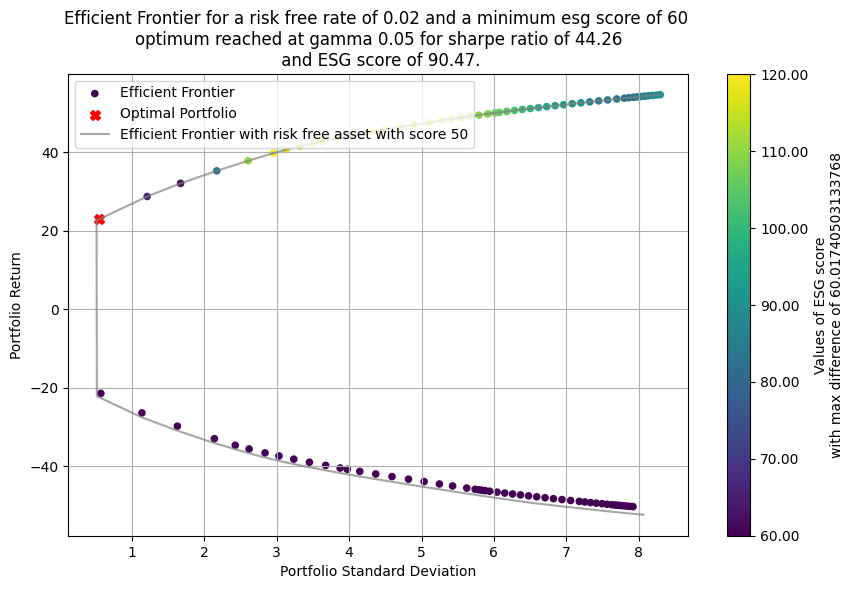

In [47]:
# efficient_frontier_60_esg_min.png
PORTFOLIO.plot_efficient_frontier(GAMMA_VALUES, 
                                  risk_free_rate=0.02,
                                  score_esg_risk_free_rate=50,
                                  max_esg_score=60, # min
                                  fully_invested=True,
                                  long_only=False,
                                  with_both_risk_free_and_without=True)


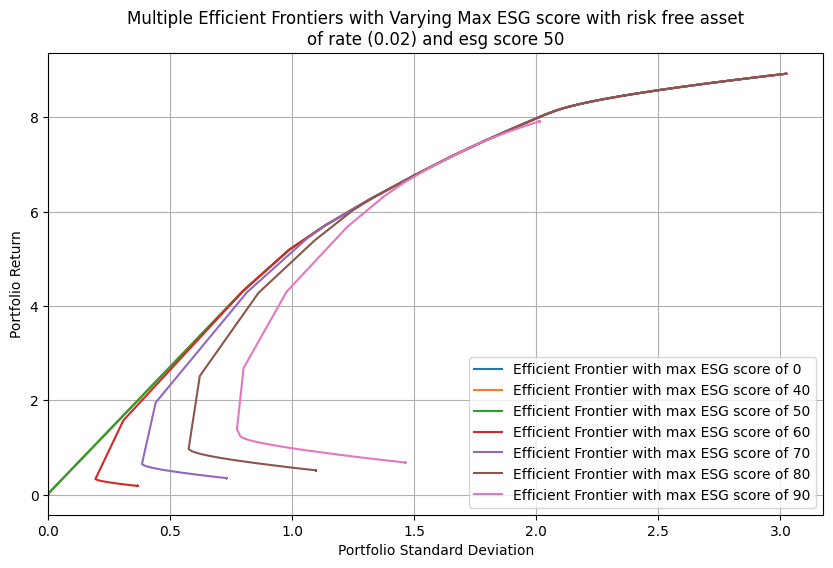

In [56]:
# multiple_efficient_frontier_esg_min_with_risk_free_asset.png
PORTFOLIO.plot_efficient_frontier_multiple_max_esg_scores(GAMMA_VALUES, 
                                  risk_free_rate=RISK_FREE_RATE,
                                  score_esg_risk_free_rate=50,
                                  max_esg_scores=[0, 40, 50, 60, 70, 80, 90],
                                  fully_invested=True,
                                  long_only=True)

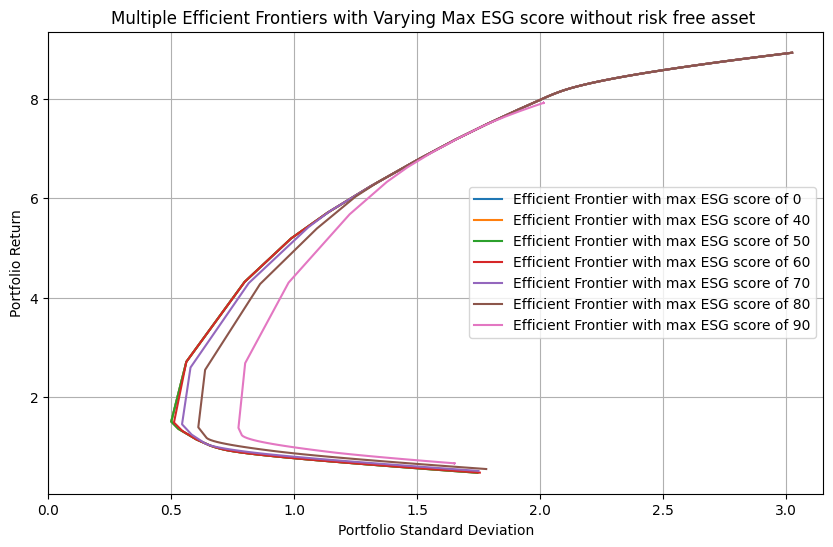

In [57]:
# multiple_efficient_frontier_esg_min_without_risk_free_asset.png
PORTFOLIO.plot_efficient_frontier_multiple_max_esg_scores(GAMMA_VALUES, 
                                  risk_free_rate=0,
                                  score_esg_risk_free_rate=50,
                                  max_esg_scores=[0, 40, 50, 60, 70, 80, 90],
                                  fully_invested=True,
                                  long_only=True)

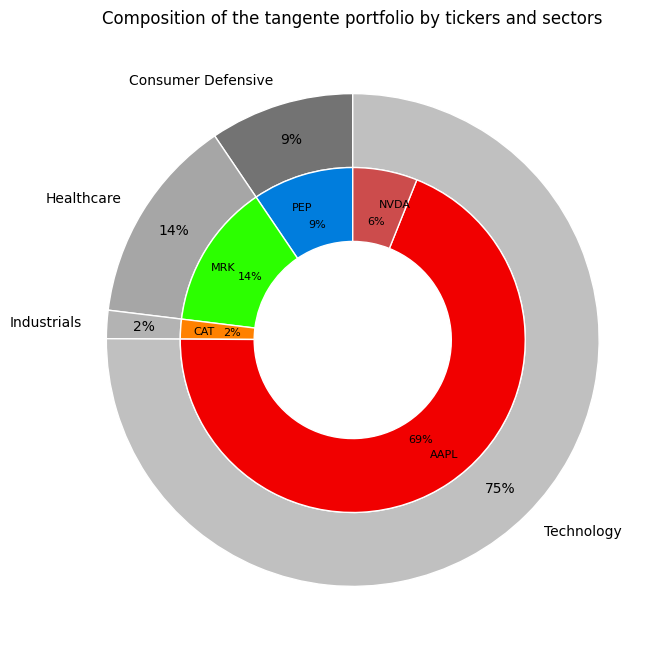

In [85]:
# tangente_portfolio_composition_no_esg_min_without_risk_free_asset.png
PORTFOLIO.plot_tangente_portfolio_composition(GAMMA_VALUES, 
                                  risk_free_rate=0,
                                  score_esg_risk_free_rate=50,
                                  max_esg_score=0,
                                  fully_invested=True,
                                  long_only=True)

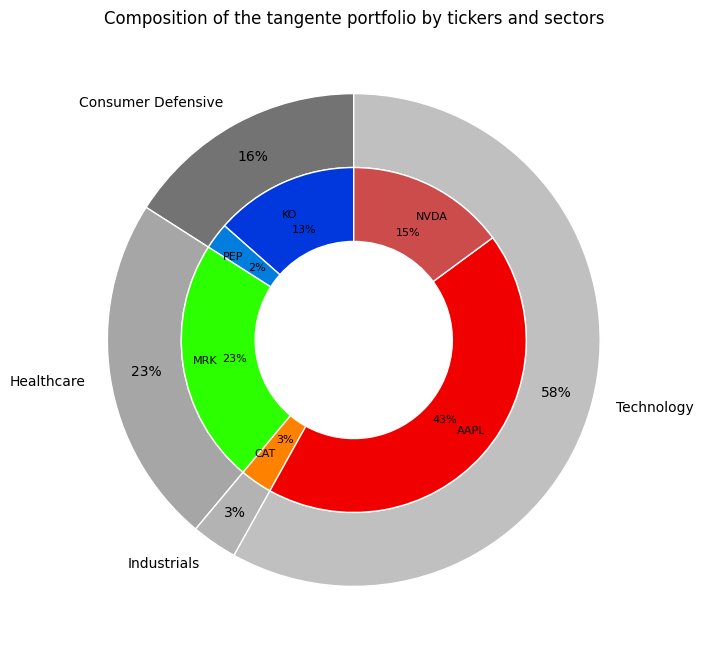

In [86]:
# tangente_portfolio_composition_70_esg_min_without_risk_free_asset.png
PORTFOLIO.plot_tangente_portfolio_composition(GAMMA_VALUES, 
                                  risk_free_rate=0,
                                  score_esg_risk_free_rate=50,
                                  max_esg_score=70,
                                  fully_invested=True,
                                  long_only=True)

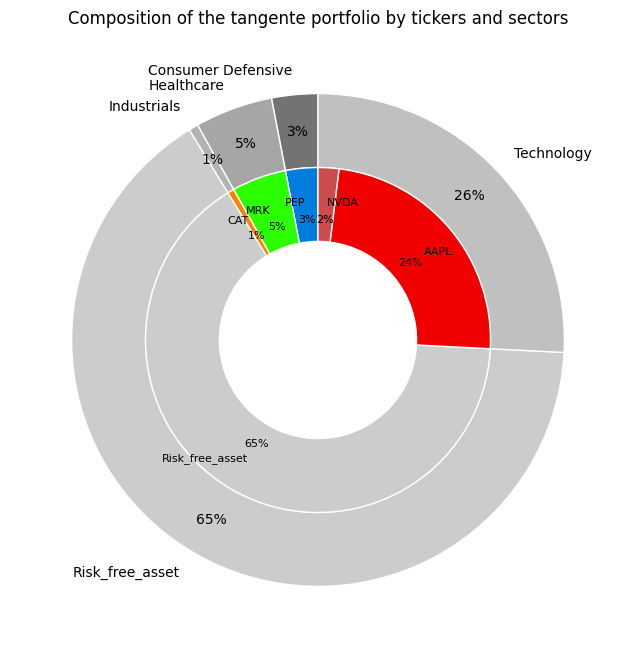

In [87]:
# tangente_portfolio_composition_no_esg_min_with_risk_free_asset.png
PORTFOLIO.plot_tangente_portfolio_composition(GAMMA_VALUES, 
                                  risk_free_rate=0.02,
                                  score_esg_risk_free_rate=50,
                                  max_esg_score=0,
                                  fully_invested=True,
                                  long_only=True)

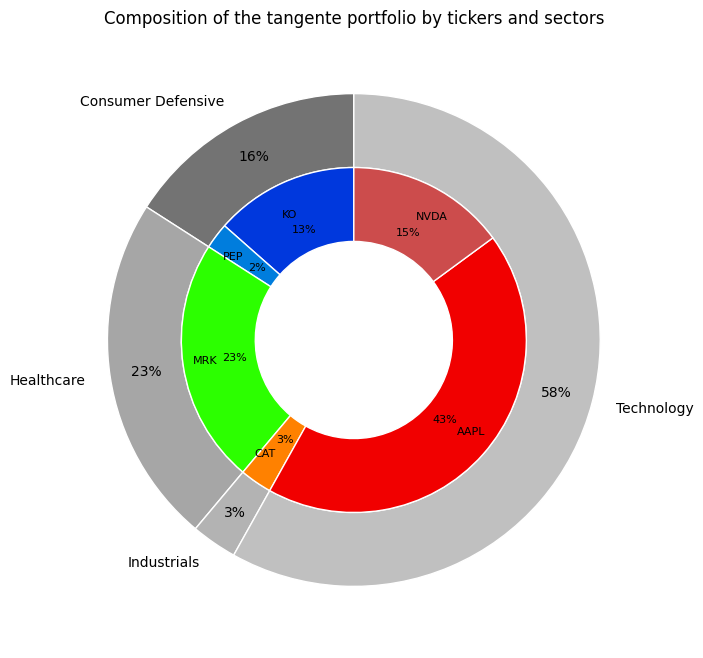

In [88]:
# tangente_portfolio_composition_70_esg_min_with_risk_free_asset.png
PORTFOLIO.plot_tangente_portfolio_composition(GAMMA_VALUES, 
                                  risk_free_rate=0.02,
                                  score_esg_risk_free_rate=50,
                                  max_esg_score=70,
                                  fully_invested=True,
                                  long_only=True)

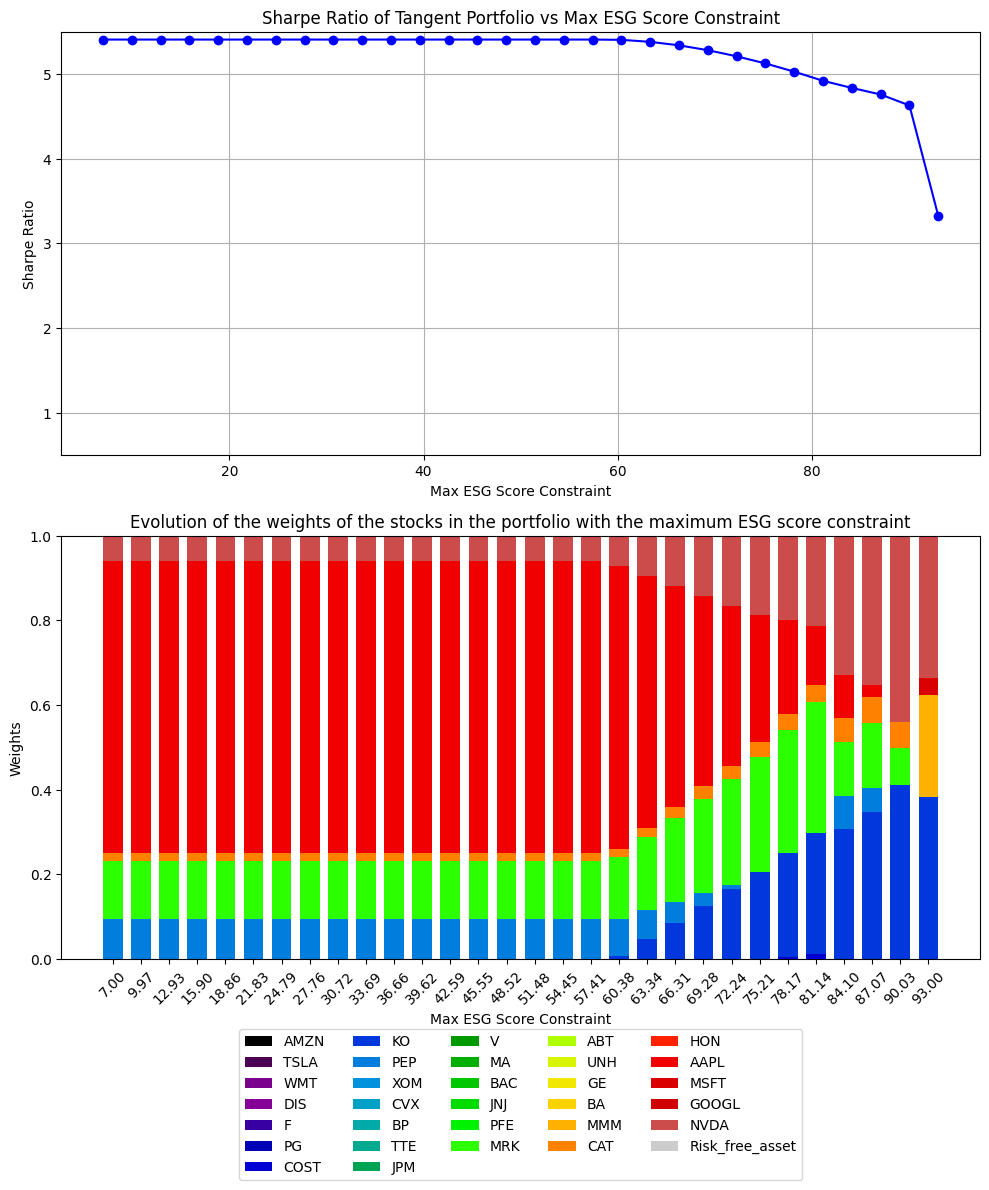

In [83]:
# sharpe_ratio_and_weights_varying_esg_limit_without_risk_free_asset.png
PORTFOLIO.plot_sharpe_ratio_and_weights_varying_esg_limit(GAMMA_VALUES,
                                        risk_free_rate=0,
                                        score_esg_risk_free_rate=50,
                                        max_esg_scores=MAX_ESG_SCORES,
                                        fully_invested=True,
                                        long_only=True,
                                        best_in_class_method=1,
                                        best_in_class_strategy='global')

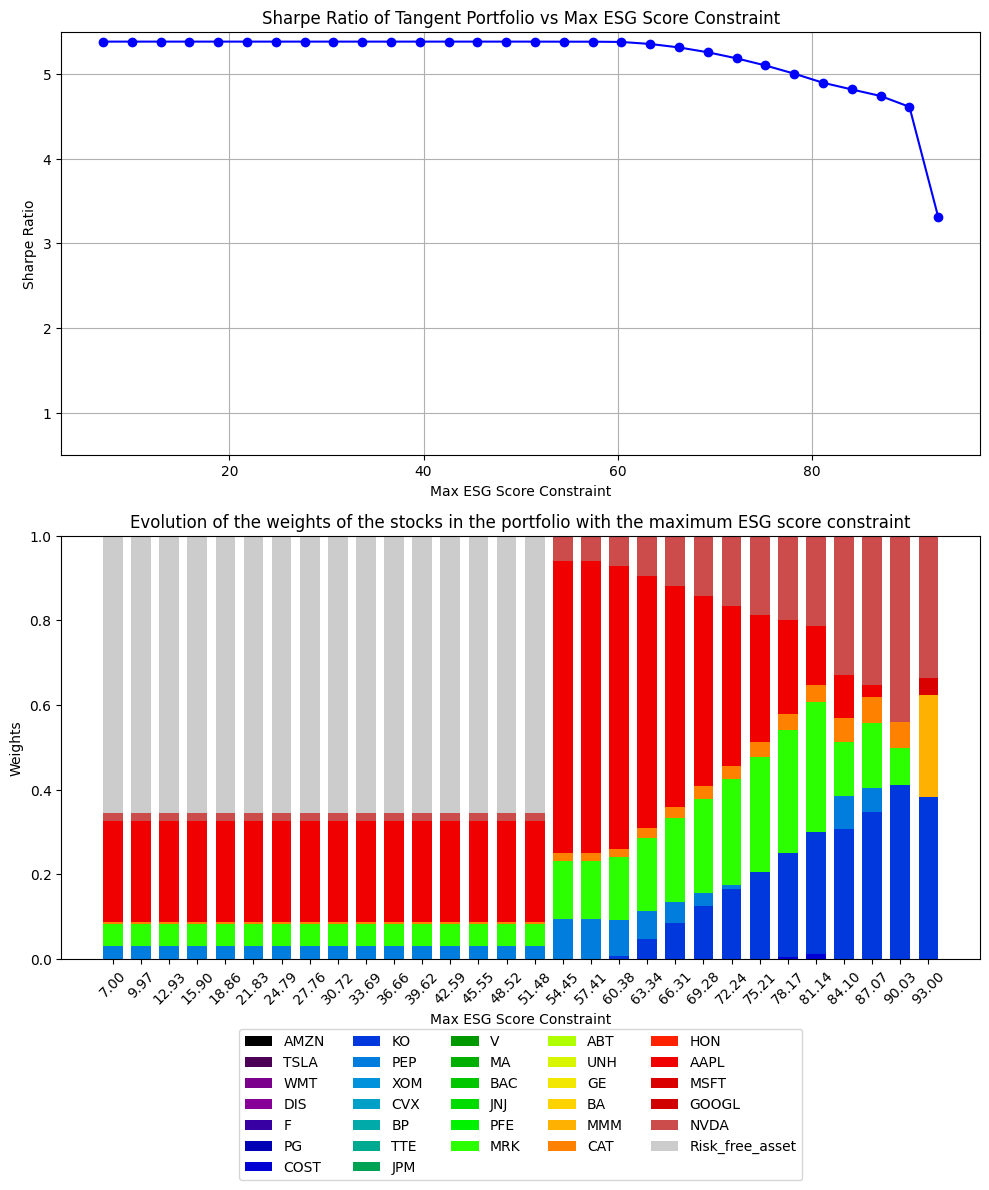

In [84]:
# sharpe_ratio_and_weights_varying_esg_limit_with_risk_free_asset.png
PORTFOLIO.plot_sharpe_ratio_and_weights_varying_esg_limit(GAMMA_VALUES,
                                        risk_free_rate=0.02,
                                        score_esg_risk_free_rate=50,
                                        max_esg_scores=MAX_ESG_SCORES,
                                        fully_invested=True,
                                        long_only=True,
                                        best_in_class_method=1,
                                        best_in_class_strategy='global')

In [95]:
# # sharp_ratio_vs_max_score.png
# PORTFOLIO.plot_sharp_ratio_vs_max_score(GAMMA_VALUES,
#                                         risk_free_rate=RISK_FREE_RATE,
#                                         max_esg_scores=MAX_ESG_SCORES,
#                                         fully_invested=True,
#                                         long_only=True,
#                                         best_in_class_method=1,
#                                         best_in_class_strategy='global')


In [96]:
# # weights_evolution_with_esg.png
# PORTFOLIO.plot_weights_evolution(GAMMA_VALUES,
#                                  risk_free_rate=RISK_FREE_RATE,
#                                  max_esg_scores=MAX_ESG_SCORES,
#                                  fully_invested=True,
#                                  long_only=True, 
#                                  best_in_class_method=1,
#                                  best_in_class_strategy='global')

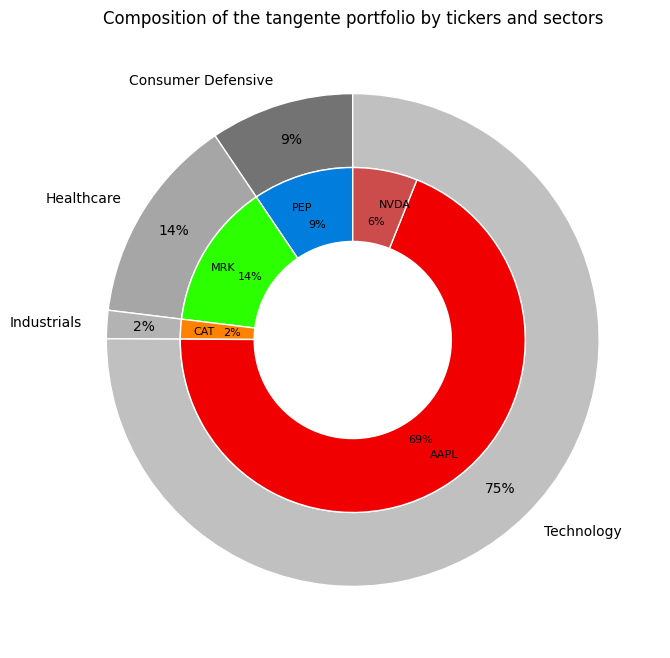

In [170]:
# tangente_portfolio_composition_55_esg_min.png
PORTFOLIO.plot_tangente_portfolio_composition(gammas=GAMMA_VALUES, 
                                            risk_free_rate=RISK_FREE_RATE,
                                            max_esg_score=55,
                                            fully_invested=True,
                                            long_only=True,
                                            best_in_class_method=1,
                                            best_in_class_strategy='global')

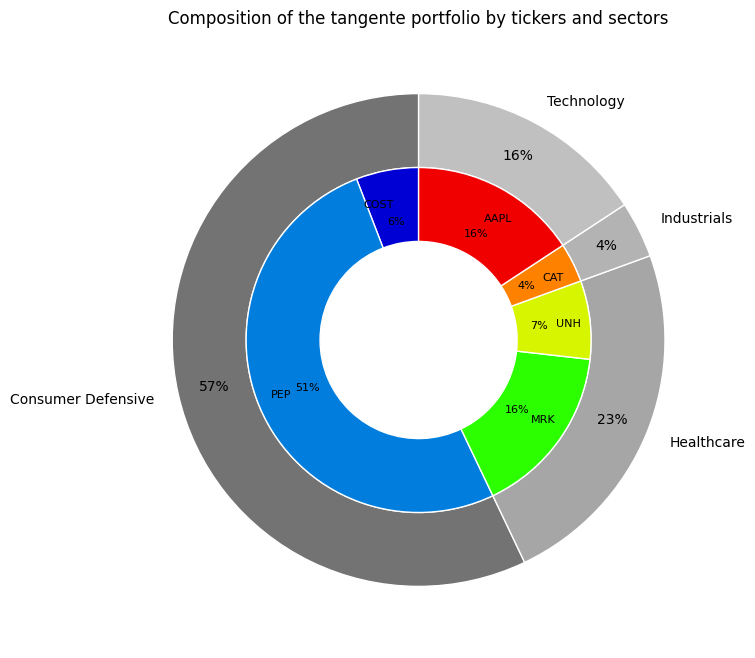

In [171]:
# tangente_portfolio_composition_73_esg_min.png
PORTFOLIO.plot_tangente_portfolio_composition(gammas=GAMMA_VALUES, 
                                            risk_free_rate=RISK_FREE_RATE,
                                            max_esg_score=73,
                                            fully_invested=True,
                                            long_only=True,
                                            best_in_class_method=1,
                                            best_in_class_strategy='global')

## 1.2. Selection 50% best global scale

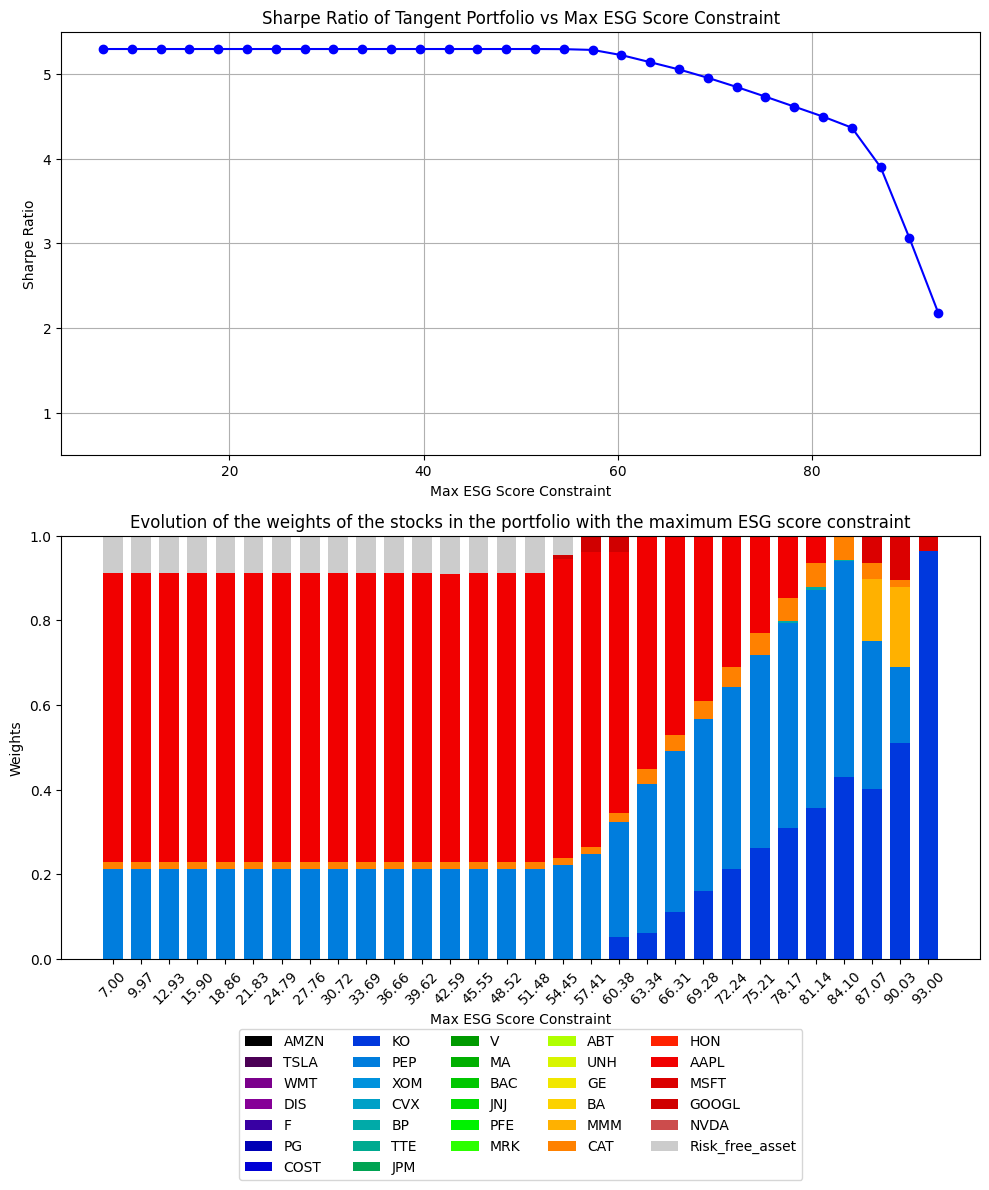

In [89]:
# sharpe_ratio_and_weights_varying_esg_limit_50_pourcent_global.png
PORTFOLIO.plot_sharpe_ratio_and_weights_varying_esg_limit(GAMMA_VALUES,
                                        risk_free_rate=0.02,
                                        max_esg_scores=MAX_ESG_SCORES,
                                        fully_invested=True,
                                        long_only=True,
                                        best_in_class_method=0.5,
                                        best_in_class_strategy='global')


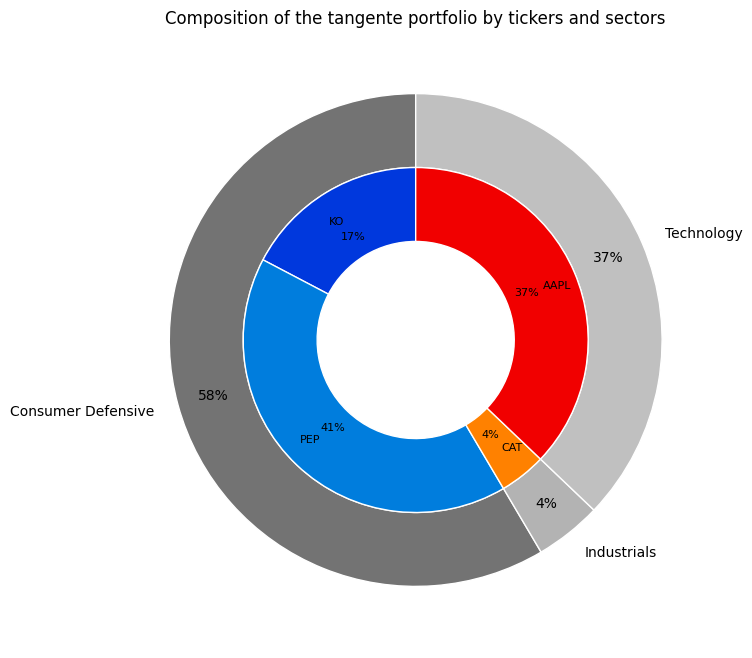

In [91]:
# tangente_portfolio_composition_70_esg_min_50_pourcent_global.png
PORTFOLIO.plot_tangente_portfolio_composition(gammas=GAMMA_VALUES, 
                                            risk_free_rate=0.02,
                                            score_esg_risk_free_rate=50,
                                            max_esg_score=70,
                                            fully_invested=True,
                                            long_only=True,
                                            best_in_class_method=0.5,
                                            best_in_class_strategy='global')

In [173]:
# # sharp_ratio_vs_max_score_50_pourcent_global.png
# PORTFOLIO.plot_sharp_ratio_vs_max_score(GAMMA_VALUES,
#                                         risk_free_rate=RISK_FREE_RATE,
#                                         max_esg_scores=MAX_ESG_SCORES,
#                                         fully_invested=True,
#                                         long_only=True,
#                                         best_in_class_method=0.5,
#                                         best_in_class_strategy='global')


In [174]:
# # weights_evolution_50_pourcent_global.png
# PORTFOLIO.plot_weights_evolution(GAMMA_VALUES,
#                                  risk_free_rate=RISK_FREE_RATE,
#                                  max_esg_scores=MAX_ESG_SCORES,
#                                  fully_invested=True,
#                                  long_only=True, 
#                                  best_in_class_method=0.5,
#                                  best_in_class_strategy='global')

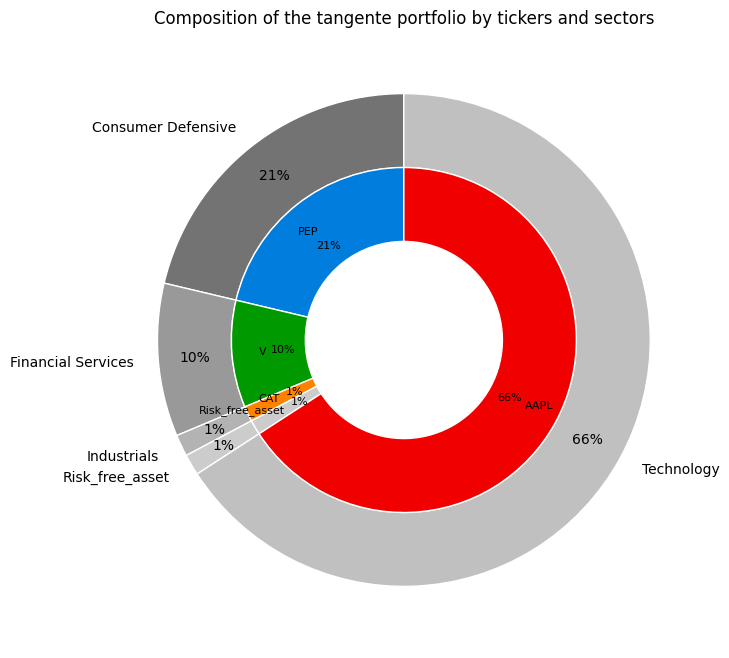

In [175]:
# tangente_portfolio_composition_no_esg_min_50_pourcent_global.png
PORTFOLIO.plot_tangente_portfolio_composition(gammas=GAMMA_VALUES, 
                                            risk_free_rate=RISK_FREE_RATE,
                                            max_esg_score=0,
                                            fully_invested=True,
                                            long_only=True,
                                            best_in_class_method=0.5,
                                            best_in_class_strategy='global')

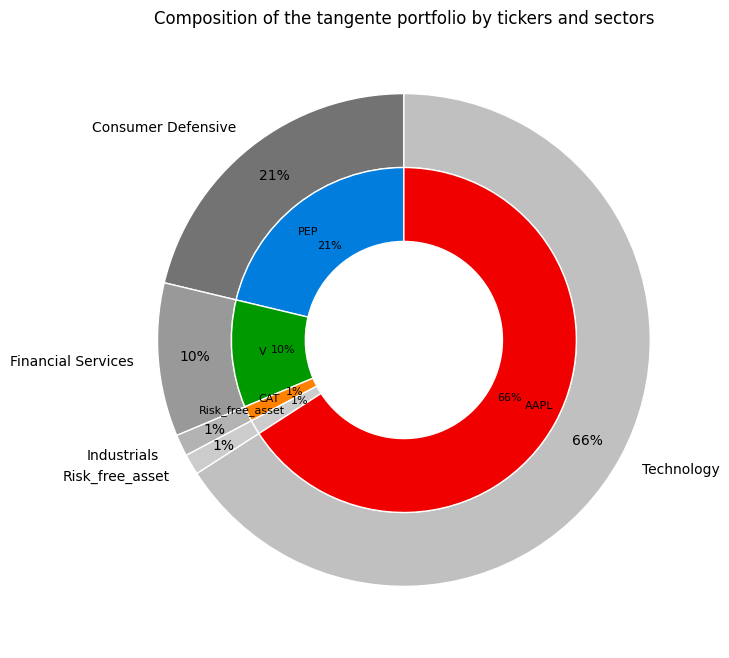

In [176]:
# tangente_portfolio_composition_55_esg_min_50_pourcent_global.png
PORTFOLIO.plot_tangente_portfolio_composition(gammas=GAMMA_VALUES, 
                                            risk_free_rate=RISK_FREE_RATE,
                                            max_esg_score=55,
                                            fully_invested=True,
                                            long_only=True,
                                            best_in_class_method=0.5,
                                            best_in_class_strategy='global')

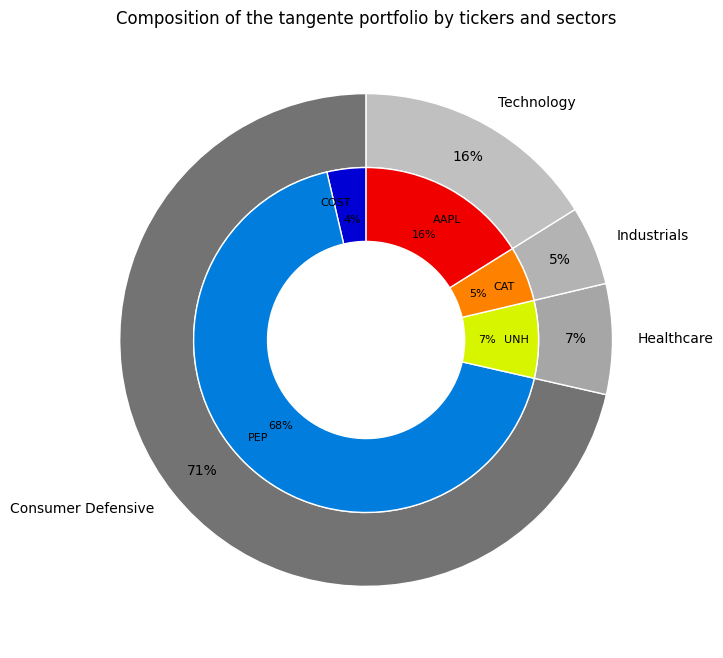

In [177]:
# tangente_portfolio_composition_73_esg_min_50_pourcent_global.png
PORTFOLIO.plot_tangente_portfolio_composition(gammas=GAMMA_VALUES, 
                                            risk_free_rate=RISK_FREE_RATE,
                                            max_esg_score=73,
                                            fully_invested=True,
                                            long_only=True,
                                            best_in_class_method=0.5,
                                            best_in_class_strategy='global')


## 1.3. Selection 50% best sector scale

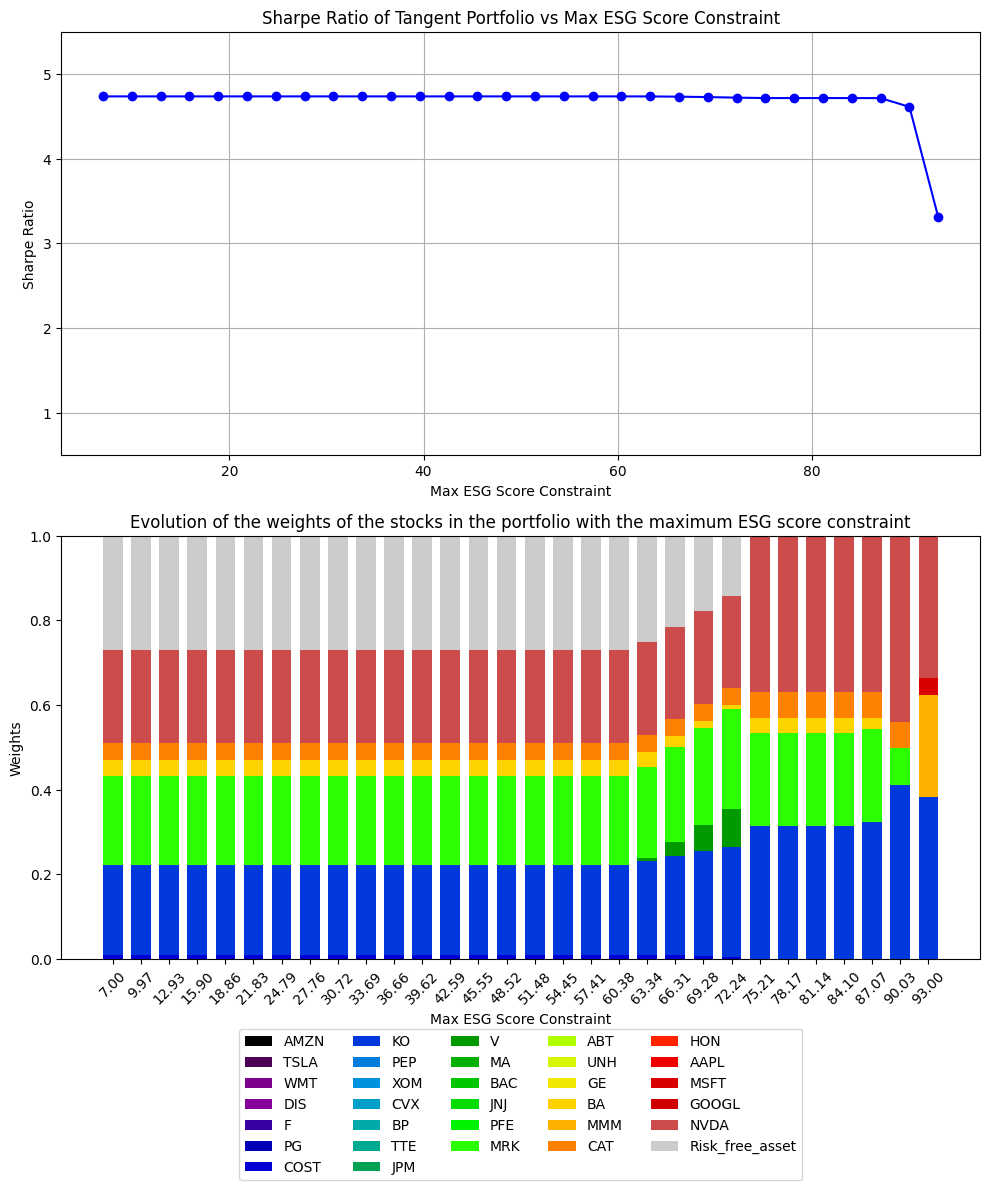

In [90]:
# sharpe_ratio_and_weights_varying_esg_limit_50_pourcent_sector.png
PORTFOLIO.plot_sharpe_ratio_and_weights_varying_esg_limit(GAMMA_VALUES,
                                        risk_free_rate=0.02,
                                        max_esg_scores=MAX_ESG_SCORES,
                                        fully_invested=True,
                                        long_only=True,
                                        best_in_class_method=0.5,
                                        best_in_class_strategy='sector')


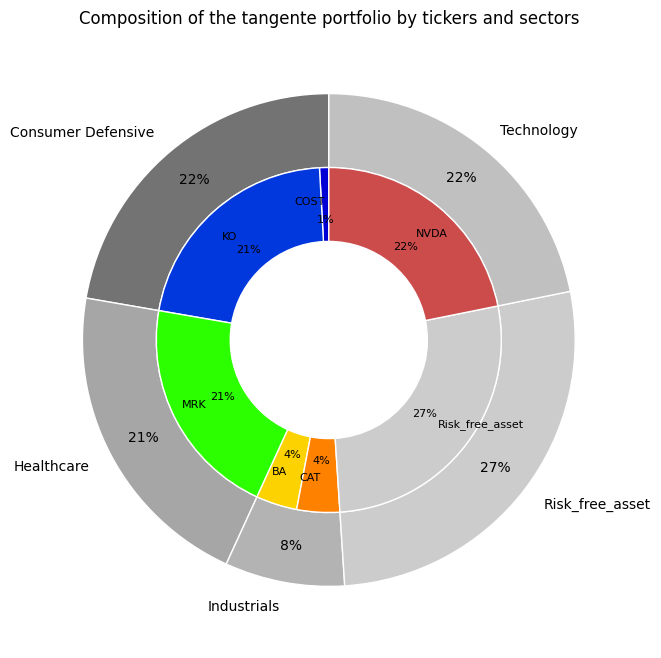

In [92]:
# tangente_portfolio_composition_70_esg_min_50_pourcent_sector.png
PORTFOLIO.plot_tangente_portfolio_composition(gammas=GAMMA_VALUES, 
                                            risk_free_rate=0.02,
                                            score_esg_risk_free_rate=50,
                                            max_esg_score=70,
                                            fully_invested=True,
                                            long_only=True,
                                            best_in_class_method=0.5,
                                            best_in_class_strategy='sector')


In [ ]:
# # sharp_ratio_vs_max_score_50_pourcent_sector.png
# PORTFOLIO.plot_sharp_ratio_vs_max_score(GAMMA_VALUES,
#                                         risk_free_rate=RISK_FREE_RATE,
#                                         max_esg_scores=MAX_ESG_SCORES,
#                                         fully_invested=True,
#                                         long_only=True,
#                                         best_in_class_method=0.5,
#                                         best_in_class_strategy='sector')


In [ ]:
# # weights_evolution_50_pourcent_sector.png
# PORTFOLIO.plot_weights_evolution(GAMMA_VALUES,
#                                  risk_free_rate=RISK_FREE_RATE,
#                                  max_esg_scores=MAX_ESG_SCORES,
#                                  fully_invested=True,
#                                  long_only=True, 
#                                  best_in_class_method=0.5,
#                                  best_in_class_strategy='sector')

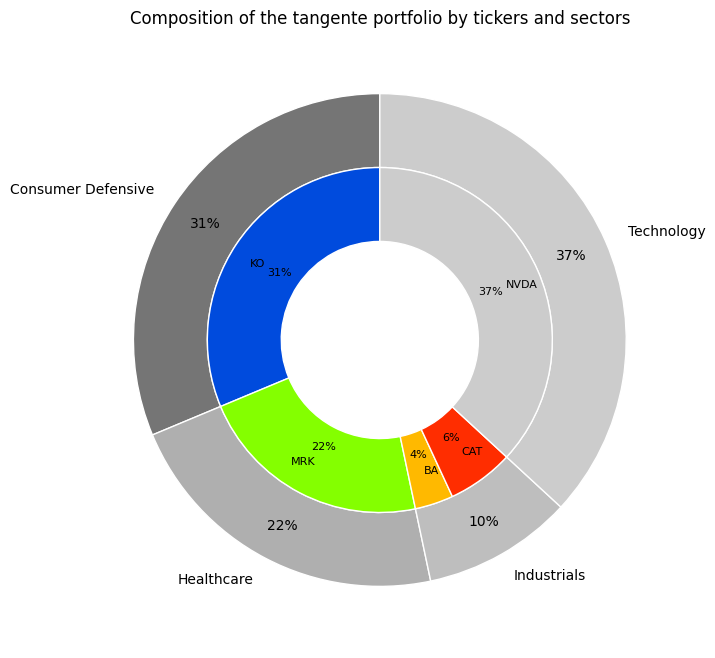

In [ ]:
# tangente_portfolio_composition_no_esg_min_50_pourcent_sector.png
PORTFOLIO.plot_tangente_portfolio_composition(gammas=GAMMA_VALUES, 
                                            risk_free_rate=RISK_FREE_RATE,
                                            max_esg_score=0,
                                            fully_invested=True,
                                            long_only=True,
                                            best_in_class_method=0.5,
                                            best_in_class_strategy='sector')


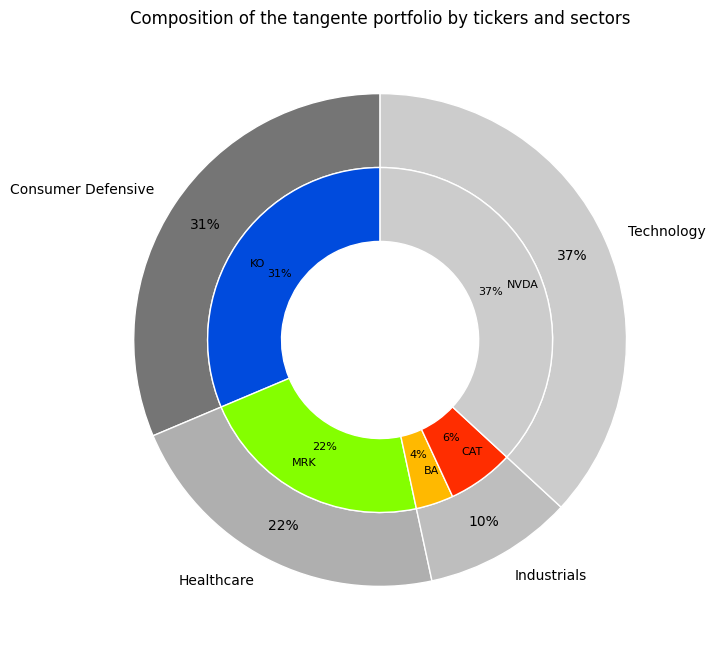

In [ ]:
# tangente_portfolio_composition_55_esg_min_50_pourcent_sector.png
PORTFOLIO.plot_tangente_portfolio_composition(gammas=GAMMA_VALUES, 
                                            risk_free_rate=RISK_FREE_RATE,
                                            max_esg_score=55,
                                            fully_invested=True,
                                            long_only=True,
                                            best_in_class_method=0.5,
                                            best_in_class_strategy='sector')


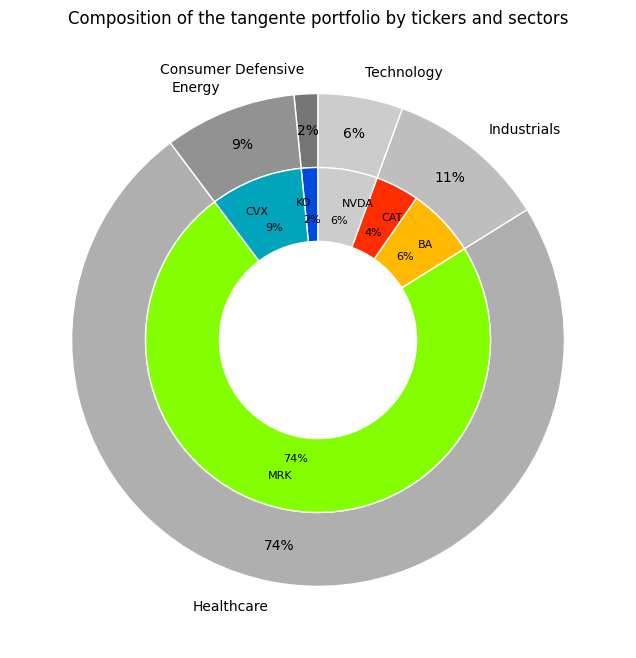

In [ ]:
# tangente_portfolio_composition_73_esg_min_50_pourcent_sector.png
PORTFOLIO.plot_tangente_portfolio_composition(gammas=GAMMA_VALUES, 
                                            risk_free_rate=RISK_FREE_RATE,
                                            max_esg_score=73,
                                            fully_invested=True,
                                            long_only=True,
                                            best_in_class_method=0.5,
                                            best_in_class_strategy='sector')


## 1.4. Fixing lower bound on investment per sector

In [8]:
# Ne devrait pas marcher 
# SECTOR_MIN_WEIGHT_X_DICT_EQUAL_WEIGHTED = {sector_name: len(set(PORTFOLIO.get_sector_for_tickers().values())) 
#                                            for sector_name in set(PORTFOLIO.get_sector_for_tickers().values())}

SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS = {'Communication Services': 0,
                                      'Consumer Cyclical': 0,
                                      'Consumer Defensive': 0,
                                      'Energy': 0.1,
                                      'Financial Services': 0,
                                      'Healthcare': 0.15,
                                      'Industrials': 0,
                                      'Technology': 0,
                                      'Risk_free_asset':0}


No solution found for esg score of 90.0344827586207
No solution found for esg score of 93.0
No solution found for esg score of 90.0344827586207
No solution found for esg score of 93.0


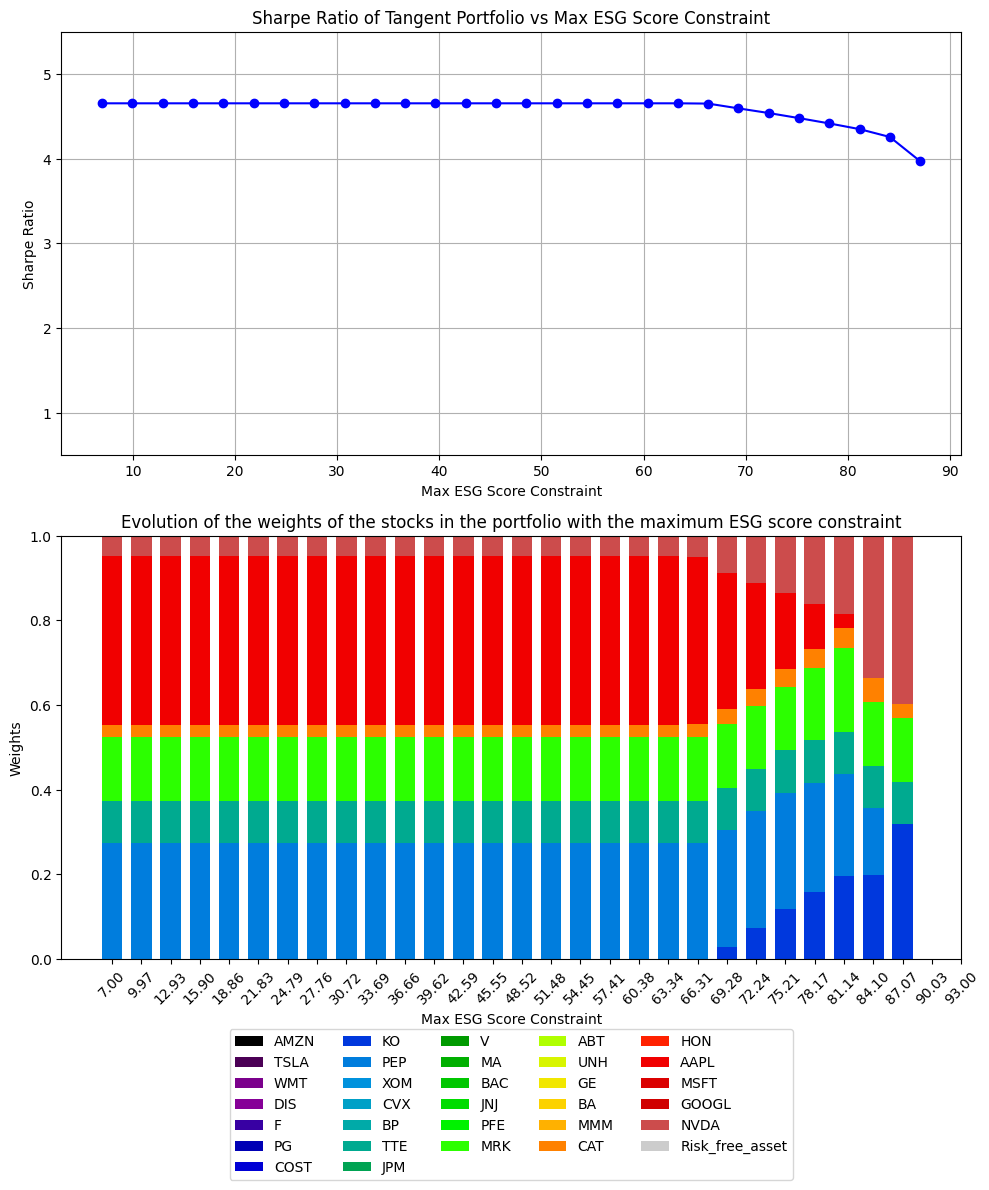

In [10]:
# sharpe_ratio_and_weights_varying_esg_limit_lower_bound_investment.png
PORTFOLIO.plot_sharpe_ratio_and_weights_varying_esg_limit(GAMMA_VALUES,
                                        risk_free_rate=0.02,
                                        score_esg_risk_free_rate=50,
                                        max_esg_scores=MAX_ESG_SCORES,
                                        fully_invested=True,
                                        long_only=True,
                                        best_in_class_method=1,
                                        best_in_class_strategy='global',
                                        sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS)


No solution found for esg score of 90.0344827586207
No solution found for esg score of 93.0
No solution found for esg score of 90.0344827586207
No solution found for esg score of 93.0


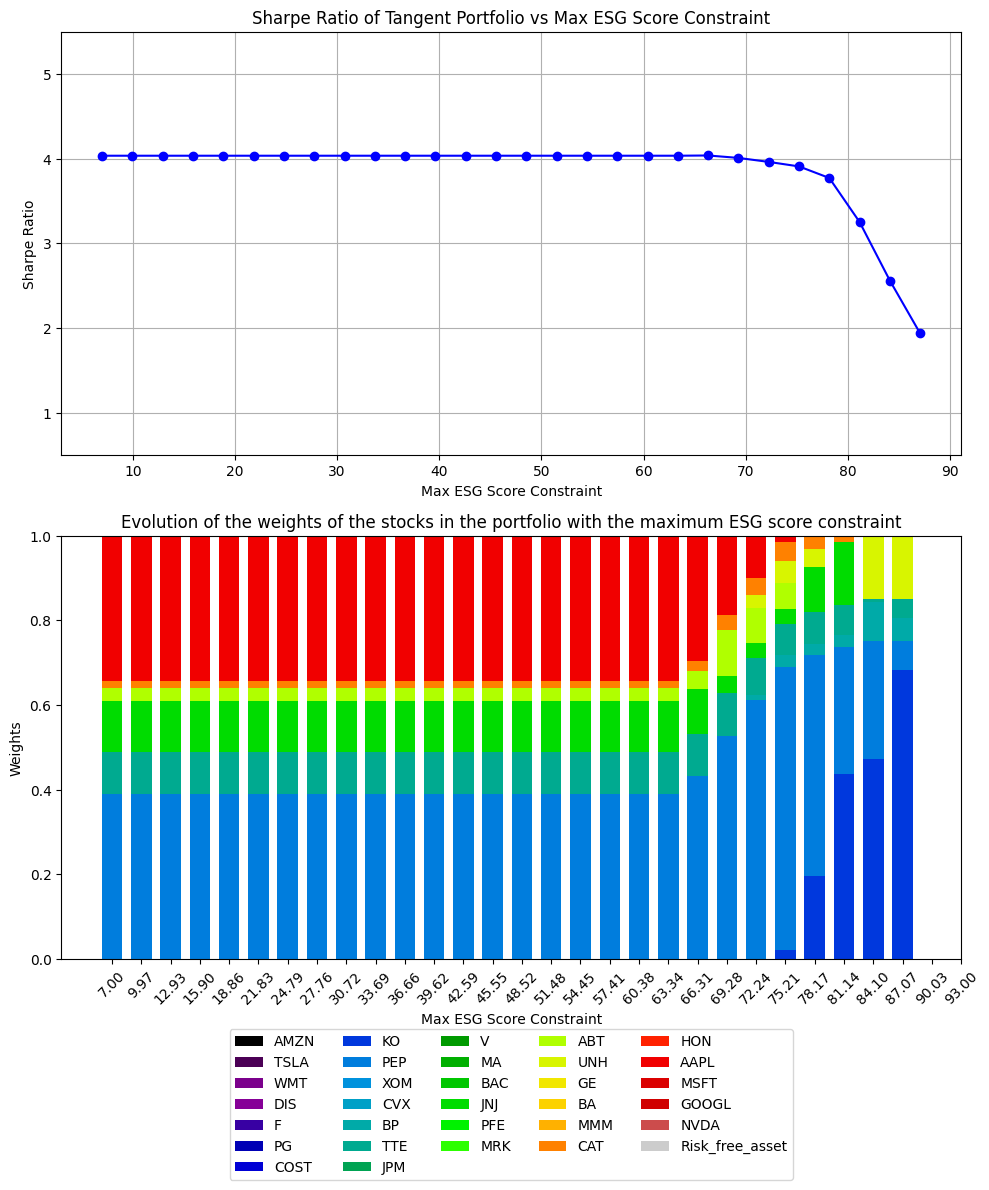

In [11]:
# sharpe_ratio_and_weights_varying_esg_limit_50_percent_global_lower_bound_investment.png
PORTFOLIO.plot_sharpe_ratio_and_weights_varying_esg_limit(GAMMA_VALUES,
                                        risk_free_rate=0.02,
                                        score_esg_risk_free_rate=50,
                                        max_esg_scores=MAX_ESG_SCORES,
                                        fully_invested=True,
                                        long_only=True,
                                        best_in_class_method=0.5,
                                        best_in_class_strategy='global',
                                        sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS)


No solution found for esg score of 90.0344827586207
No solution found for esg score of 93.0
No solution found for esg score of 90.0344827586207
No solution found for esg score of 93.0


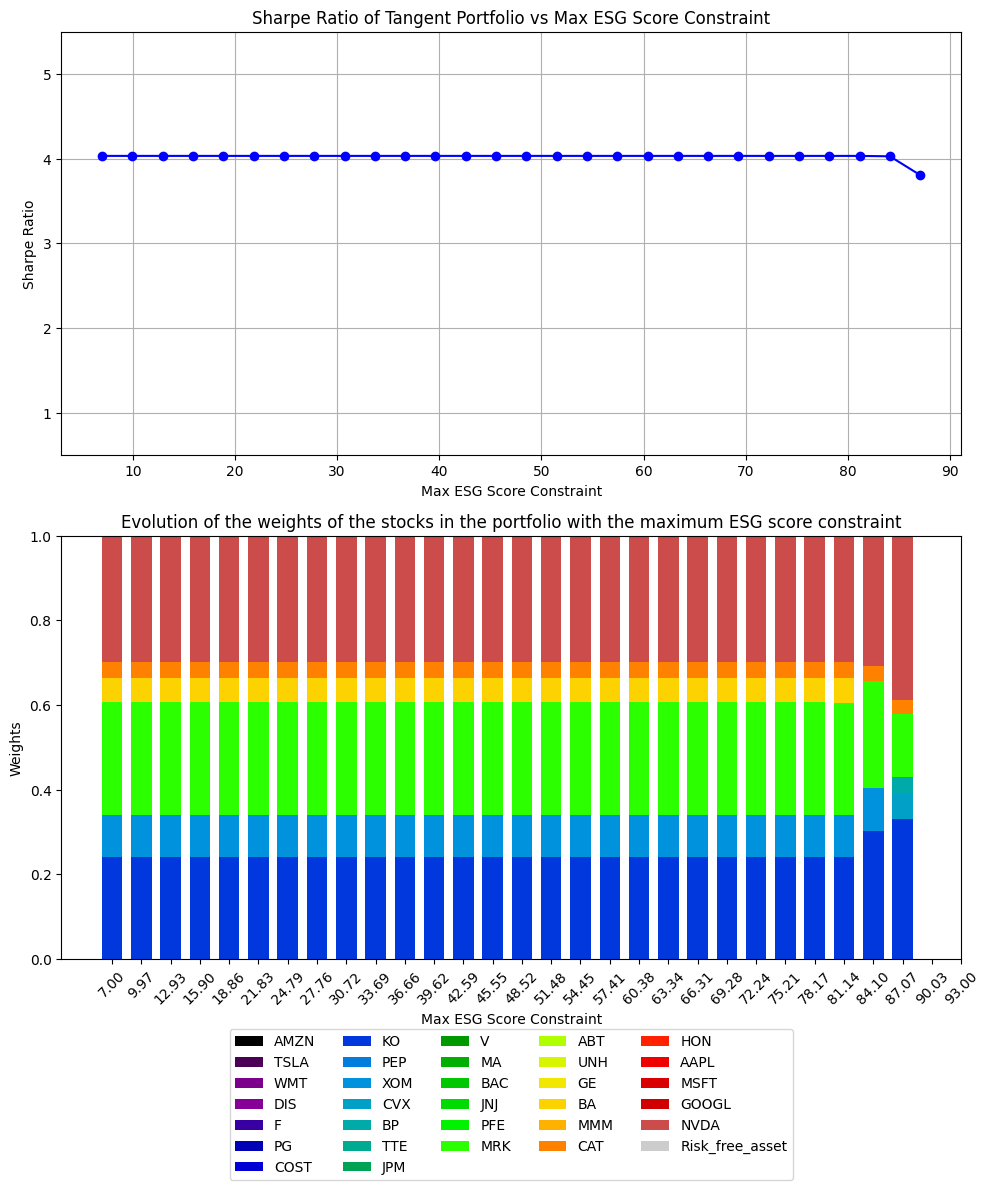

In [12]:
# sharpe_ratio_and_weights_varying_esg_limit_50_percent_sector_lower_bound_investment.png
PORTFOLIO.plot_sharpe_ratio_and_weights_varying_esg_limit(GAMMA_VALUES,
                                        risk_free_rate=0.02,
                                        score_esg_risk_free_rate=50,
                                        max_esg_scores=MAX_ESG_SCORES,
                                        fully_invested=True,
                                        long_only=True,
                                        best_in_class_method=0.5,
                                        best_in_class_strategy='sector',
                                        sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS)


### 1.4.1. Lower bound - Market optimum

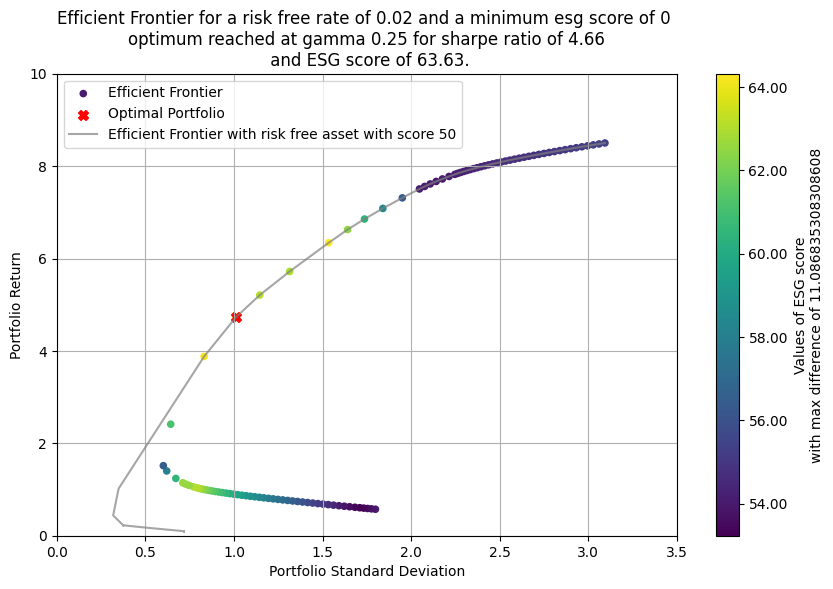

In [124]:
# efficient_frontier_no_esg_min_sector_lower_bound_investment.png
PORTFOLIO.plot_efficient_frontier(GAMMA_VALUES, 
                                  risk_free_rate=0.02,
                                  score_esg_risk_free_rate=50,
                                  max_esg_score=0,
                                  fully_invested=True,
                                  long_only=True,
                                  with_both_risk_free_and_without=True,
                                  sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS)

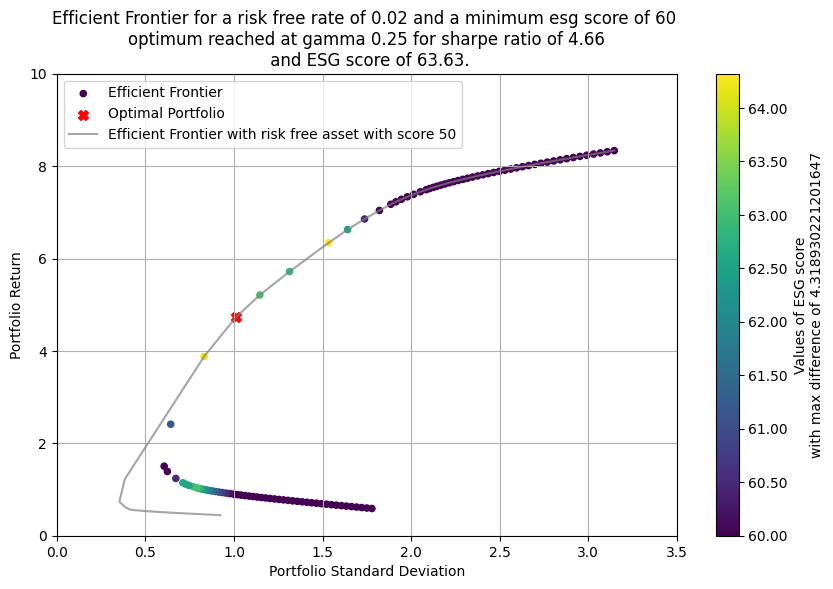

In [125]:
# efficient_frontier_60_esg_min_sector_lower_bound_investment.png
PORTFOLIO.plot_efficient_frontier(GAMMA_VALUES, 
                                  risk_free_rate=0.02,
                                  score_esg_risk_free_rate=50,
                                  max_esg_score=60,
                                  fully_invested=True,
                                  long_only=True,
                                  with_both_risk_free_and_without=True,
                                  sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS)

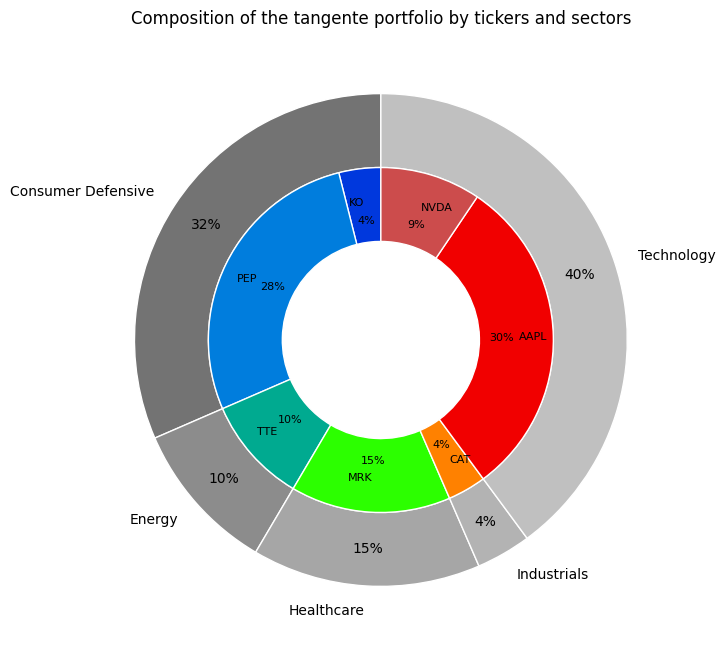

In [9]:
# tangente_portfolio_composition_70_esg_min_sector_lower_bound_investment.png
PORTFOLIO.plot_tangente_portfolio_composition(GAMMA_VALUES, 
                                  risk_free_rate=0.02,
                                  score_esg_risk_free_rate=50,
                                  max_esg_score=70,
                                  fully_invested=True,
                                  long_only=True,
                                  sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS)

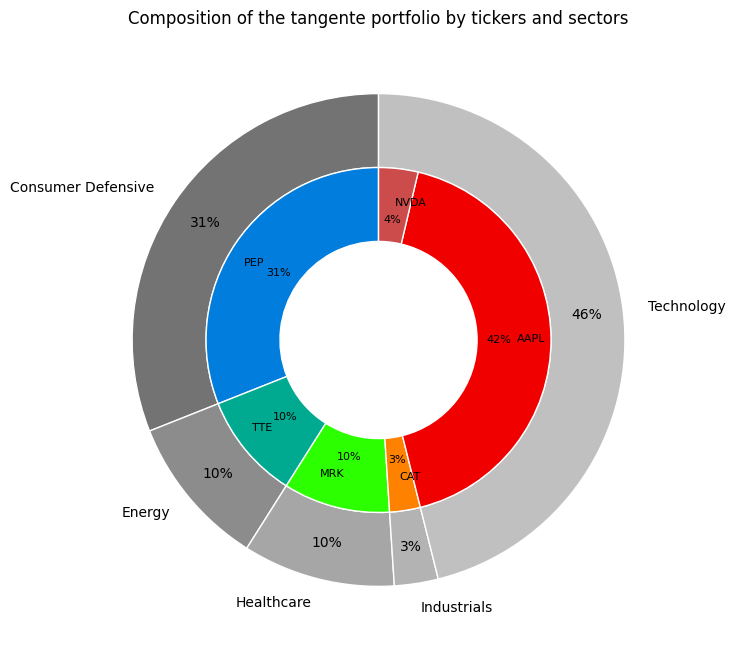

In [128]:
# tangente_portfolio_composition_60_esg_min_lower_bound_investment.png
PORTFOLIO.plot_tangente_portfolio_composition(GAMMA_VALUES, 
                                  risk_free_rate=0.02,
                                  score_esg_risk_free_rate=50,
                                  max_esg_score=60,
                                  fully_invested=True,
                                  long_only=True,
                                  sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS)

In [ ]:
# # sharp_ratio_vs_max_score_60_esg_min_lower_bound_investment.png
# PORTFOLIO.plot_sharp_ratio_vs_max_score(GAMMA_VALUES,
#                                         risk_free_rate=RISK_FREE_RATE,
#                                         max_esg_scores=MAX_ESG_SCORES,
#                                         fully_invested=True,
#                                         long_only=True,
#                                         best_in_class_method=1,
#                                         best_in_class_strategy='global',
#                                         sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS)


In [ ]:
# # weights_evolution_60_esg_min_all_lower_bound_investment.png
# PORTFOLIO.plot_weights_evolution(GAMMA_VALUES,
#                                  risk_free_rate=RISK_FREE_RATE,
#                                  max_esg_scores=MAX_ESG_SCORES,
#                                  fully_invested=True,
#                                  long_only=True, 
#                                  best_in_class_method=1,
#                                  best_in_class_strategy='global',
#                                  sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS)


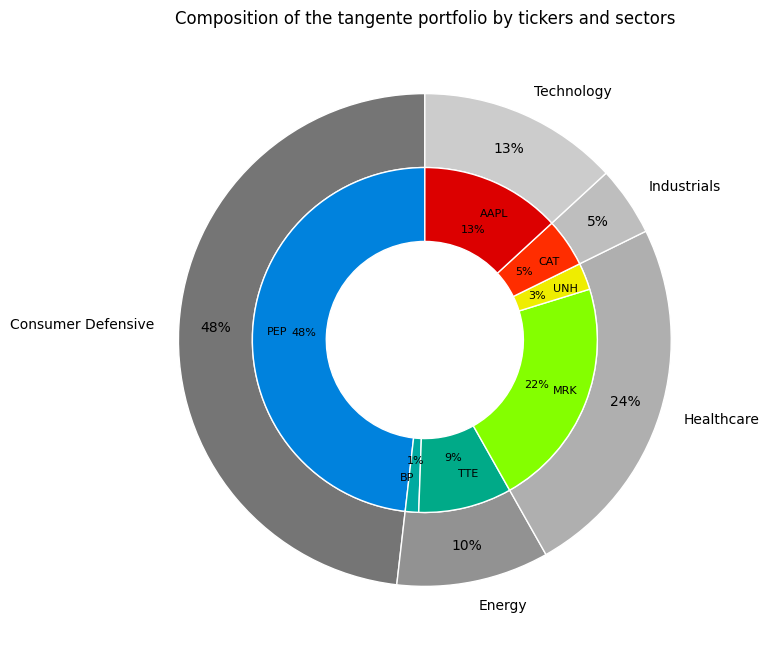

In [121]:
# tangente_portfolio_composition_73_esg_min_all_lower_bound_investment.png
PORTFOLIO.plot_tangente_portfolio_composition(gammas=GAMMA_VALUES, 
                                            risk_free_rate=RISK_FREE_RATE,
                                            max_esg_score=73,
                                            fully_invested=True,
                                            long_only=True,
                                            best_in_class_method=1,
                                            best_in_class_strategy='global',
                                            sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS)

### 1.4.2. Lower bound - 50% sector

No solution found for esg score of 79.0
No solution found for esg score of 79.0


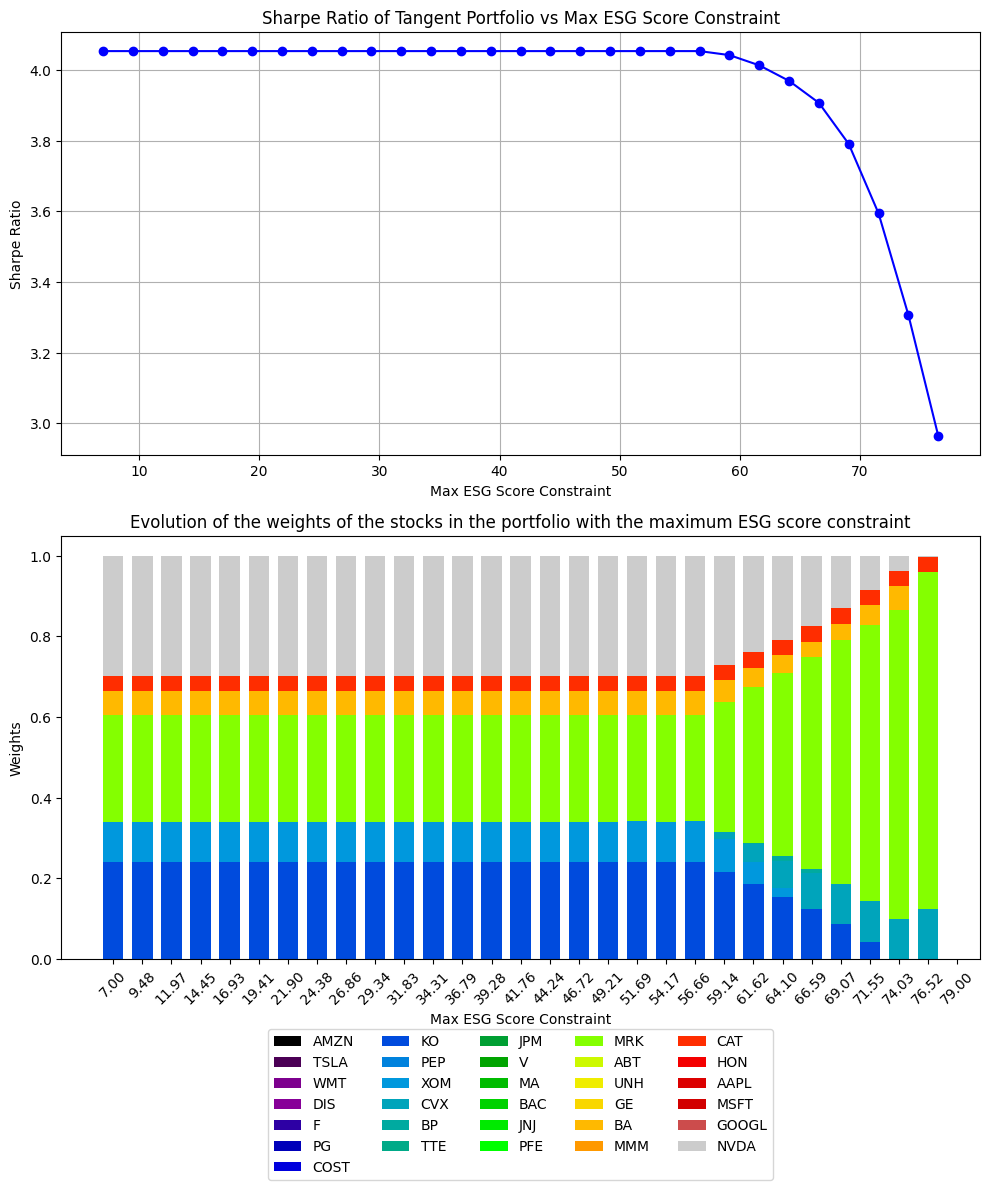

In [ ]:
# sharpe_ratio_and_weights_varying_esg_limit_50_percent_sector_lower_bound_investment.png
PORTFOLIO.plot_sharpe_ratio_and_weights_varying_esg_limit(GAMMA_VALUES,
                                        risk_free_rate=0.02,
                                        max_esg_scores=MAX_ESG_SCORES,
                                        fully_invested=True,
                                        long_only=True,
                                        best_in_class_method=0.5,
                                        best_in_class_strategy='sector',
                                        sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS)


In [112]:
# # sharp_ratio_vs_max_score_60_esg_min_all_lower_bound_investment.png
# PORTFOLIO.plot_sharp_ratio_vs_max_score(GAMMA_VALUES,
#                                         risk_free_rate=RISK_FREE_RATE,
#                                         max_esg_scores=MAX_ESG_SCORES,
#                                         fully_invested=True,
#                                         long_only=True,
#                                         best_in_class_method=1,
#                                         best_in_class_strategy='sector',
#                                         sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS)



In [113]:
# # sharp_ratio_vs_max_score_60_esg_min_90_pourcent_sector_lower_bound_investment.png
# PORTFOLIO.plot_sharp_ratio_vs_max_score(GAMMA_VALUES,
#                                         risk_free_rate=RISK_FREE_RATE,
#                                         max_esg_scores=MAX_ESG_SCORES,
#                                         fully_invested=True,
#                                         long_only=True,
#                                         best_in_class_method=0.9,
#                                         best_in_class_strategy='sector',
#                                         sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS)



In [114]:
# # sharp_ratio_vs_max_score_60_esg_min_80_pourcent_sector_lower_bound_investment.png
# PORTFOLIO.plot_sharp_ratio_vs_max_score(GAMMA_VALUES,
#                                         risk_free_rate=RISK_FREE_RATE,
#                                         max_esg_scores=MAX_ESG_SCORES,
#                                         fully_invested=True,
#                                         long_only=True,
#                                         best_in_class_method=0.8,
#                                         best_in_class_strategy='sector',
#                                         sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS)



In [115]:
# # sharp_ratio_vs_max_score_60_esg_min_50_pourcent_sector_lower_bound_investment.png
# PORTFOLIO.plot_sharp_ratio_vs_max_score(GAMMA_VALUES,
#                                         risk_free_rate=RISK_FREE_RATE,
#                                         max_esg_scores=MAX_ESG_SCORES,
#                                         fully_invested=True,
#                                         long_only=True,
#                                         best_in_class_method=0.5,
#                                         best_in_class_strategy='sector',
#                                         sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS)



In [116]:
# # sharp_ratio_vs_max_score_60_esg_min_20_pourcent_sector_lower_bound_investment.png
# PORTFOLIO.plot_sharp_ratio_vs_max_score(GAMMA_VALUES,
#                                         risk_free_rate=RISK_FREE_RATE,
#                                         max_esg_scores=MAX_ESG_SCORES,
#                                         fully_invested=True,
#                                         long_only=True,
#                                         best_in_class_method=0.2,
#                                         best_in_class_strategy='sector',
#                                         sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS)



In [117]:
# # sharp_ratio_vs_max_score_60_esg_min_10_pourcent_sector_lower_bound_investment.png
# PORTFOLIO.plot_sharp_ratio_vs_max_score(GAMMA_VALUES,
#                                         risk_free_rate=RISK_FREE_RATE,
#                                         max_esg_scores=MAX_ESG_SCORES,
#                                         fully_invested=True,
#                                         long_only=True,
#                                         best_in_class_method=0.1,
#                                         best_in_class_strategy='sector',
#                                         sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS)



In [118]:
# # weights_evolution_60_esg_min_80_pourcent_sector_lower_bound_investment.png
# PORTFOLIO.plot_weights_evolution(GAMMA_VALUES,
#                                  risk_free_rate=RISK_FREE_RATE,
#                                  max_esg_scores=MAX_ESG_SCORES,
#                                  fully_invested=True,
#                                  long_only=True, 
#                                  best_in_class_method=0.8,
#                                  best_in_class_strategy='sector',
#                                  sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS)


In [119]:
# # weights_evolution_60_esg_min_50_pourcent_sector_lower_bound_investment.png
# PORTFOLIO.plot_weights_evolution(GAMMA_VALUES,
#                                  risk_free_rate=RISK_FREE_RATE,
#                                  max_esg_scores=MAX_ESG_SCORES,
#                                  fully_invested=True,
#                                  long_only=True, 
#                                  best_in_class_method=0.5,
#                                  best_in_class_strategy='sector',
#                                  sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS)


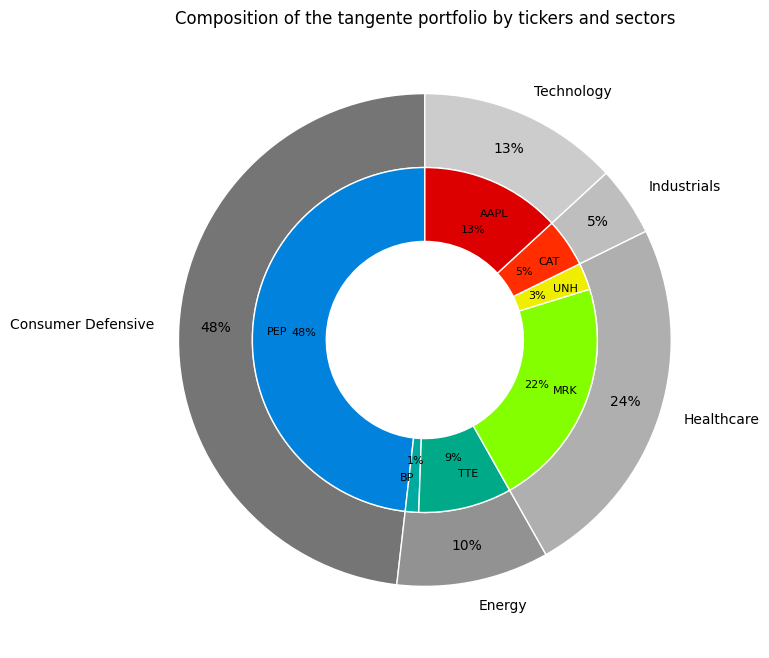

In [80]:
# weights_evolution_73_esg_min_80_pourcent_sector_lower_bound_investment.png
PORTFOLIO.plot_tangente_portfolio_composition(gammas=GAMMA_VALUES, 
                                            risk_free_rate=RISK_FREE_RATE,
                                            max_esg_score=73,
                                            fully_invested=True,
                                            long_only=True,
                                            best_in_class_method=0.8,
                                            best_in_class_strategy='sector',
                                            sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS)

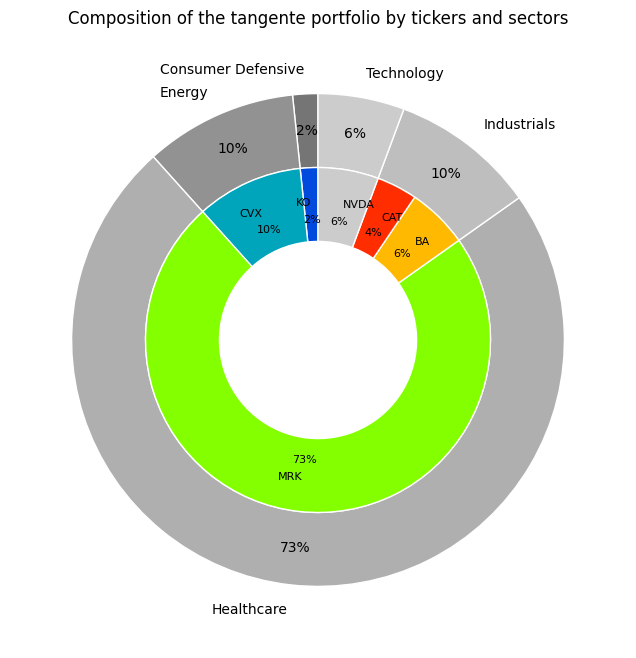

In [81]:
# weights_evolution_73_esg_min_50_pourcent_sector_lower_bound_investment.png
PORTFOLIO.plot_tangente_portfolio_composition(gammas=GAMMA_VALUES, 
                                            risk_free_rate=RISK_FREE_RATE,
                                            max_esg_score=73,
                                            fully_invested=True,
                                            long_only=True,
                                            best_in_class_method=0.5,
                                            best_in_class_strategy='sector',
                                            sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS)

# 2. Test portfolio performance on unseen data

In [268]:
def check_if_dates_are_correct(T0, T1, T2):
    if datetime.strptime(T1, '%Y-%m-%d') < get_first_date_with_all_msci_score_available(msci_score):
        print("ERROR: END_DATE is before the first date with all msci score available.")
        T1 = get_first_date_with_all_msci_score_available(msci_score)
        print(f"T1 is now {T1}, but you can change it.")
    else:
        print("Thanks for having entered a valid end date !")


def get_tangente_ptf_weights(T0, 
                             T1,
                             msci_score, 
                             TICKERS, 
                             INTERVAL, 
                             RISK_FREE_RATE, 
                             FREQUENCY_RETURNS, 
                             GAMMA_VALUES, 
                             min_esg_score,
                             fully_invested=True,
                             long_only=True,
                             best_in_class_method=1,
                             best_in_class_strategy='global',
                             sector_min_weight_x_dict=None):

    msci_last_esg_score = get_last_esg_scores(msci_score, T1)

    PTF = Portfolio(tickers=TICKERS,
                    start_date=T0,
                    end_date=T1,
                    interval=INTERVAL,
                    msci_data=msci_last_esg_score,
                    frequency_returns=FREQUENCY_RETURNS)
    
    PTF.download_data()

    PTF.get_optimal_portfolio_markowitz(gammas=GAMMA_VALUES, 
                                                  risk_free_rate=RISK_FREE_RATE,
                                                  max_esg_score=min_esg_score,
                                                  fully_invested=fully_invested,
                                                  long_only=long_only,
                                                  best_in_class_method=best_in_class_method,
                                                  best_in_class_strategy=best_in_class_strategy,
                                                  sector_min_weight_x_dict=sector_min_weight_x_dict)
    
    weights = PTF.weights_tangente_portfolio
    esg_score_tangent = PTF.score_esg_tangent
    

    return weights, esg_score_tangent

def test_tangente_ptf_weights(weights,
                              T1_bis,
                              T2,
                              msci_score,
                              TICKERS,
                              INTERVAL,
                              FREQUENCY_RETURNS):
    
    msci_last_esg_score = get_last_esg_scores(msci_score, T2)

    PTF = Portfolio(tickers=TICKERS,
                    start_date=T1_bis,
                    end_date=T2,
                    interval=INTERVAL,
                    msci_data=msci_last_esg_score,
                    frequency_returns=FREQUENCY_RETURNS)
    
    PTF.get_net_returns()

    return weights, PTF.net_returns, msci_last_esg_score


def get_tangent_ptf_evolution(T0, 
                              T1, 
                              T1_bis,
                              T2, 
                              msci_score, 
                              TICKERS, 
                              INTERVAL, 
                              RISK_FREE_RATE, 
                              FREQUENCY_RETURNS, 
                              GAMMA_VALUES, 
                              min_esg_score,
                              fully_invested=True,
                              long_only=True,
                              best_in_class_method=1,
                              best_in_class_strategy='global',
                              sector_min_weight_x_dict=None,
                              initial_value=None):
    
    weights, esg_score_tangent = get_tangente_ptf_weights(T0, 
                             T1,
                             msci_score, 
                             TICKERS, 
                             INTERVAL, 
                             RISK_FREE_RATE, 
                             FREQUENCY_RETURNS, 
                             GAMMA_VALUES, 
                             min_esg_score,
                             fully_invested,
                             long_only,
                             best_in_class_method,
                             best_in_class_strategy,
                             sector_min_weight_x_dict)
    
    weights, net_returns, msci_last_esg_score = test_tangente_ptf_weights(weights,
                                                                      T1_bis,
                                                                      T2,
                                                                      msci_score,
                                                                      TICKERS,
                                                                      INTERVAL,
                                                                      FREQUENCY_RETURNS)
                              


    # Calculate weighted returns
    weighted_returns = net_returns.dot(weights)

    # Calculate portfolio value
    portfolio_return = (1 + weighted_returns).prod()

    if initial_value is not None:
        portfolio_value = initial_value * portfolio_return
        print("Portfolio value:", portfolio_value)

    print("Portfolio return:", round(portfolio_return, 2))
    print("Portfolio esg score at T1:", esg_score_tangent)
    print("Portfolio esg score at T2:", np.array(msci_last_esg_score) @ weights)


In [269]:
T0='2020-01-01'
T1='2022-12-01'
T1_bis='2022-01-01'
T2='2023-12-01'

check_if_dates_are_correct(T0, T1, T2)

Thanks for having entered a valid end date !


In [270]:
get_tangent_ptf_evolution(T0, 
                              T1, 
                              T1_bis,
                              T2, 
                              msci_score, 
                              TICKERS, 
                              INTERVAL, 
                              RISK_FREE_RATE, 
                              FREQUENCY_RETURNS, 
                              GAMMA_VALUES, 
                              min_esg_score=70,
                              fully_invested=True,
                              long_only=True,
                              best_in_class_method=1,
                              best_in_class_strategy='global',
                              sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS,
                              initial_value=100)

[                       0%%                      ]

[*********************100%%**********************]  31 of 31 completed
[*********************100%%**********************]  31 of 31 completed
Portfolio value: 12253.236795510133
Portfolio return: 122.53
Portfolio esg score at T1: 70.00000000000105
Portfolio esg score at T2: 69.06617578911543


In [271]:
for max_score in list(np.linspace(65, np.max(msci_last_esg_score), 15)):
    print(f"Max score: {max_score}")
    get_tangent_ptf_evolution(T0, 
                            T1, 
                            T1_bis,
                            T2, 
                            msci_score, 
                            TICKERS, 
                            INTERVAL, 
                            RISK_FREE_RATE, 
                            FREQUENCY_RETURNS, 
                            GAMMA_VALUES, 
                            min_esg_score=max_score,
                            fully_invested=True,
                            long_only=True,
                            best_in_class_method=1,
                            best_in_class_strategy='global',
                            sector_min_weight_x_dict=None)

Max score: 65.0


[*********************100%%**********************]  31 of 31 completed
[*********************100%%**********************]  31 of 31 completed
Portfolio return: 1887.04
Portfolio esg score at T1: 65.00000000000018
Portfolio esg score at T2: 61.65000636123805
Max score: 66.0
[*********************100%%**********************]  31 of 31 completed
[*********************100%%**********************]  31 of 31 completed
Portfolio return: 4846.39
Portfolio esg score at T1: 66.00000000000021
Portfolio esg score at T2: 62.367966595647424
Max score: 67.0
[*********************100%%**********************]  31 of 31 completed
[*********************100%%**********************]  31 of 31 completed
Portfolio return: 11028.13
Portfolio esg score at T1: 67.00000000000021
Portfolio esg score at T2: 63.112651058049806
Max score: 68.0
[*********************100%%**********************]  31 of 31 completed
[*********************100%%**********************]  31 of 31 completed
Portfolio return: 23657.36
Portfo

In [ ]:
# get weights of tangent portfolio under desired constraints
# test allocation return, vol, (sharp ratio) and esg score Y months later

In [ ]:
#TODO

#2. Backtest analyses
# train l'optimisation entre T0 et T1 -> renvoie des weights
# test les weights sur la période T1 et T2 -> renvoie un score de performance + analyse de si on respecte encore les contraintes esg en T2 (moyenne, variance etc.)
# faire cela pour les différents cas précédement identifiés (1 global, 0.5 global, 0.5 local ET ajout ou non de contraintes sectorielles)

#3. comparer à Sustainalytics ajrd (interval de confiance sur le score ESG?)

# Récap: vérifier les contraintes au cours du temps (les plots) et comparer à des indices ou des ptf equal weights.
# Répéter l'allocation chaque année et comparer comment la frontière efficiente évolue au cours du temps